In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from hypopt import GridSearch

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 75

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# Preprocessing

In [3]:
training_path = '/glade/work/jdubeau/job-metrics-training.json'
data_types = {'dsnum':'object'}

df = pd.read_json(training_path, dtype = data_types)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50360 entries, 6132011 to 6785810
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   request_type     50360 non-null  object             
 1   job_start_at     50360 non-null  datetime64[ns]     
 2   job_end_at       50360 non-null  datetime64[ns]     
 3   used_mem         50360 non-null  float64            
 4   dsnum            48150 non-null  object             
 5   rqst_start_at    50327 non-null  datetime64[ns, UTC]
 6   rqst_end_at      50248 non-null  datetime64[ns, UTC]
 7   dates_init       50360 non-null  bool               
 8   slat             32123 non-null  float64            
 9   nlat             32123 non-null  float64            
 10  wlon             32140 non-null  float64            
 11  elon             32140 non-null  float64            
 12  gui              50360 non-null  bool               
 13  paramete

## Adding new features

Adding wall time (time from job start to job end).
This will be measured in seconds.

In [4]:
def calculate_walltime(row):
    end = row['job_end_at']
    start = row['job_start_at']
    return (end - start) / np.timedelta64(1, 's')

df['wall_time'] = df.apply(lambda row: calculate_walltime(row),
                            axis = 1)


Adding request timespan (length of time requested in the data).
This will be measured in days.

In [5]:
df['rqst_timespan'] = df.apply(lambda row:
                               (row['rqst_end_at'] - row['rqst_start_at']) / np.timedelta64(1, 'D'),
                               axis = 1)


Adding a number of features which are just the length of a list. This includes 
number of grid definitions, number of levels, number of products, and number
of stations.

In [6]:
def list_length_feature(feature, row, sep = ','):
    if row[feature] != None:
        return len(row[feature].split(sep))
    else:
        return 0

In [7]:
df['grid_def_num'] = df.apply(lambda row: list_length_feature('grid_definition', row), axis = 1)
df['level_num'] = df.apply(lambda row: list_length_feature('level', row), axis = 1)
df['product_num'] = df.apply(lambda row: list_length_feature('product', row), axis = 1)
df['station_num'] = df.apply(lambda row: list_length_feature('station', row, sep = ' '), axis = 1)

Number of parameters is similar to the four features above, but the parameters could be separated by either spaces or commas.

In [8]:
def make_params_num(row):
    if row['parameters'] != None:
        sep = ',' if ',' in row['parameters'] else ' '
        return list_length_feature('parameters', row, sep = sep)
    else:
        return 0

df['params_num'] = df.apply(lambda row: make_params_num(row), axis = 1)

We also add the rectangle area of the subset of data requested.

In [9]:
def request_area(row):
    return abs((row['nlat'] - row['slat']) * (row['elon'] - row['wlon']))

df['rqst_area_rect'] = df.apply(lambda row: request_area(row), axis = 1)

We add three columns which encode what type of request the job was.
(Purge requests can be identified from the other three columns -- 
they are neither PP, SP, nor BR.)

In [10]:
for rtype in ['PP', 'SP', 'BR']:
    df[rtype] = df.apply(lambda row: True if row['request_type'] == rtype else False, axis = 1)

Next we add a boolean column representing whether the data was converted to a different format (which is true if and only if a value for "format" was present in the rinfo string).

In [11]:
df['converted'] = df.apply(lambda row: True if row['format'] != None else False,
                           axis = 1)

Now we add boolean columns to encode the dataset: one column for each of the 
five most common datasets (so a False value in all five columsn means "other.")

In [12]:
most_common = df['dsnum'].value_counts()[:5].index.tolist()

for common_id in most_common:
    column_name = 'ds' + common_id
    df[column_name] = df.apply(lambda row: row['dsnum'] == common_id, axis = 1)


## Handling missing values

If rqst_area_rect is null, just fill it with zero (experimental)

In [17]:
df['rqst_area_rect'] = df.apply(lambda row: 
                                0 if row['rqst_area_rect'] != row['rqst_area_rect'] 
                                else row['rqst_area_rect'], 
                                axis=1)

# Exploration / visualization

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50360 entries, 6132011 to 6785810
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   request_type     50360 non-null  object             
 1   job_start_at     50360 non-null  datetime64[ns]     
 2   job_end_at       50360 non-null  datetime64[ns]     
 3   used_mem         50360 non-null  float64            
 4   dsnum            48150 non-null  object             
 5   rqst_start_at    50327 non-null  datetime64[ns, UTC]
 6   rqst_end_at      50248 non-null  datetime64[ns, UTC]
 7   dates_init       50360 non-null  bool               
 8   slat             32123 non-null  float64            
 9   nlat             32123 non-null  float64            
 10  wlon             32140 non-null  float64            
 11  elon             32140 non-null  float64            
 12  gui              50360 non-null  bool               
 13  paramete

# Wall time model

## Feature selection

In [18]:
time_df = df[df.rqst_timespan.notnull() & df.rqst_area_rect.notnull()]
time_X_features = ['PP', 'SP', 'BR', 'rqst_timespan', 'rqst_area_rect', 'converted',
              'params_num', 'grid_def_num', 'level_num',
              'ds084.1', 'ds631.1', 'ds083.3', 'ds094.0', 'ds083.2']
time_y_features = ['wall_time']

time_X = time_df[time_X_features]
time_y = time_df[time_y_features]

## Train/validation/test split

In [19]:
time_train_amt = 0.5
time_val_amt = 0.25
time_test_amt = 0.25

In [20]:
time_X_train, time_X_target, time_y_train, time_y_target = \
                train_test_split(time_X, time_y, 
                test_size=1-time_train_amt, 
                random_state = 3)
time_X_val, time_X_test, time_y_val, time_y_test = \
                train_test_split(time_X_target, time_y_target,
                                 test_size = time_test_amt/time_train_amt,
                                 random_state = 3)


In [21]:
time_y_train = np.ravel(time_y_train)
time_y_val = np.ravel(time_y_val)
time_y_test = np.ravel(time_y_test)

## Scaling

In [22]:
time_scaler = StandardScaler()
time_scaler.fit(time_X_train)

time_X_train_norm = time_scaler.transform(time_X_train)
time_X_val_norm = time_scaler.transform(time_X_val)
time_X_test_norm = time_scaler.transform(time_X_test)

## Trees, Forest, Gradient Boosts

### Tree

In [43]:
time_tree_param_grid = {'random_state':[3], 'max_depth':range(2,15)}
time_tree_gs = GridSearch(model=DecisionTreeRegressor(), 
                          param_grid=time_tree_param_grid,
                          parallelize=False)
time_tree_gs.fit(time_X_train_norm, time_y_train, time_X_val_norm, time_y_val)

DecisionTreeRegressor(max_depth=14, random_state=3)

In [44]:
time_tree_gs.best_params

{'max_depth': 14, 'random_state': 3}

In [45]:
time_tree = DecisionTreeRegressor(**time_tree_gs.best_params)
#time_tree_params = {'max_depth': 14, 'random_state': 3}
time_tree = DecisionTreeRegressor(**time_tree_params)
time_tree.fit(time_X_train_norm, time_y_train)

DecisionTreeRegressor(max_depth=14, random_state=3)

### Forest

In [46]:
time_forest_param_grid = {'random_state':[3], 'max_depth':range(2,15),
                     'n_estimators':[100,200,300,500]}
time_forest_gs = GridSearch(model=RandomForestRegressor(), 
                            param_grid=time_forest_param_grid,
                            parallelize=False)
time_forest_gs.fit(time_X_train_norm, time_y_train, time_X_val_norm, time_y_val)

RandomForestRegressor(max_depth=14, n_estimators=500, random_state=3)

In [47]:
time_forest_gs.best_params

{'max_depth': 14, 'n_estimators': 500, 'random_state': 3}

In [48]:
time_forest = RandomForestRegressor(**time_forest_gs.best_params)
time_forest_params = {'max_depth': 14, 'n_estimators': 500, 'random_state': 3}
#time_forest = RandomForestRegressor(**time_forest_params)
time_forest.fit(time_X_train_norm, time_y_train)

RandomForestRegressor(max_depth=14, n_estimators=500, random_state=3)

### Gradient boosted trees

In [49]:
time_gboost_param_grid = {'random_state':[3], 
                          'max_depth':range(2,15),
                          'n_estimators':[100,200,300,500]}
time_gboost_gs = GridSearch(model=GradientBoostingRegressor(),
                            param_grid=time_gboost_param_grid,
                            parallelize=False)
time_gboost_gs.fit(time_X_train_norm, time_y_train, time_X_val_norm, time_y_val)

GradientBoostingRegressor(max_depth=14, n_estimators=500, random_state=3)

In [50]:
time_gboost_gs.best_params

{'max_depth': 9, 'n_estimators': 100, 'random_state': 3}

In [51]:
time_gboost = GradientBoostingRegressor(**time_gboost_gs.best_params)
time_gboost_params = {'max_depth': 9, 'n_estimators': 200, 'random_state': 3}
#time_gboost = GradientBoostingRegressor(**time_gboost_params)
time_gboost.fit(time_X_train_norm, time_y_train)

GradientBoostingRegressor(max_depth=9, random_state=3)

## Linear regressors

### Basic linear regression

In [79]:
linear = LinearRegression().fit(time_X_train_norm, time_y_train)

In [80]:
linear.coef_

array([-3.08079625e+14, -1.98081955e+14, -2.54545409e+14,  4.09936246e+02,
        9.24035133e+02,  5.35986768e+02,  3.32524213e+02, -5.40387383e+02,
        1.44827068e+02, -9.60060109e+01, -8.36605917e+02, -4.69981956e+02,
       -2.87397389e+02, -5.13149092e+02])

### Ridge regression

In [81]:
ridge10 = Ridge(alpha=10).fit(time_X_train_norm, time_y_train)
ridge1 = Ridge(alpha=1).fit(time_X_train_norm, time_y_train)
ridge01 = Ridge(alpha=0.1).fit(time_X_train_norm, time_y_train)

In [82]:
ridge10.coef_

array([ 238.41904502, -327.61101366,  -33.6215843 ,  410.04491288,
        923.84245443,  535.69893656,  332.02432887, -539.81108984,
        144.72743864,  -95.18195939, -835.71471171, -469.27537967,
       -287.28410071, -512.4821674 ])

### Lasso regression

In [83]:
lasso = Lasso(alpha=0.01, max_iter=100000).fit(time_X_train_norm, time_y_train)

In [84]:
lasso.coef_

array([ 279.36155795, -301.48185274,   -0.        ,  410.08392359,
        924.07130643,  536.04727082,  332.52449962, -540.33185348,
        144.83334318,  -95.69897379, -836.42658642, -469.81757402,
       -287.34595195, -512.98899119])

# Used memory model

In [52]:
mem_df = df[df.rqst_timespan.notnull() & df.rqst_area_rect.notnull()]
mem_X_features = ['PP', 'SP', 'BR', 'rqst_timespan', 'rqst_area_rect', 'converted',
              'params_num', 'grid_def_num', 'level_num',
              'ds084.1', 'ds631.1', 'ds083.3', 'ds094.0', 'ds083.2']
mem_y_features = ['used_mem']

mem_X = mem_df[mem_X_features]
mem_y = mem_df[mem_y_features]

## Train/validation/test split

In [53]:
mem_train_amt = 0.5
mem_val_amt = 0.25
mem_test_amt = 0.25

In [54]:
mem_X_train, mem_X_target, mem_y_train, mem_y_target = \
                        train_test_split(mem_X, mem_y, 
                                         test_size=1-mem_train_amt, 
                                         random_state = 3)
mem_X_val, mem_X_test, mem_y_val, mem_y_test = \
                        train_test_split(mem_X_target, mem_y_target,
                                         test_size = mem_test_amt/mem_train_amt,
                                         random_state = 3)


In [55]:
mem_y_train = np.ravel(mem_y_train)
mem_y_val = np.ravel(mem_y_val)
mem_y_test = np.ravel(mem_y_test)

## Scaling

In [56]:
mem_scaler = StandardScaler()
mem_scaler.fit(mem_X_train)

mem_X_train_norm = mem_scaler.transform(mem_X_train)
mem_X_val_norm = mem_scaler.transform(mem_X_val)
mem_X_test_norm = mem_scaler.transform(mem_X_test)

## Trees, Forest, Gradient Boosts

### Tree

In [57]:
mem_tree_param_grid = {'random_state':[3], 'max_depth':range(2,15)}
mem_tree_gs = GridSearch(model=DecisionTreeRegressor(), 
                         param_grid=mem_tree_param_grid,
                         parallelize=False)
mem_tree_gs.fit(mem_X_train_norm, mem_y_train, mem_X_val_norm, mem_y_val)


DecisionTreeRegressor(max_depth=14, random_state=3)

In [58]:
mem_tree_gs.best_params

{'max_depth': 13, 'random_state': 3}

In [59]:
mem_tree_params = {'max_depth': 11, 'random_state': 3}
mem_tree = DecisionTreeRegressor(**mem_tree_gs.best_params)
#mem_tree = DecisionTreeRegressor(**mem_tree_params)
mem_tree.fit(mem_X_train_norm, mem_y_train)

DecisionTreeRegressor(max_depth=13, random_state=3)

### Forest

In [60]:
mem_forest_param_grid = {'random_state':[3], 'max_depth':range(2,15),
                     'n_estimators':[100,200,300,500]}
mem_forest_gs = GridSearch(model=RandomForestRegressor(), 
                           param_grid=mem_forest_param_grid,
                           parallelize=False)
mem_forest_gs.fit(mem_X_train_norm, mem_y_train, mem_X_val_norm, mem_y_val)

RandomForestRegressor(max_depth=14, n_estimators=500, random_state=3)

In [61]:
mem_forest_gs.best_params

{'max_depth': 9, 'n_estimators': 200, 'random_state': 3}

In [62]:
mem_forest = RandomForestRegressor(**mem_forest_gs.best_params)
mem_forest_params = {'max_depth': 13, 'n_estimators': 100, 'random_state': 3}
#mem_forest = RandomForestRegressor(**mem_forest_params)
mem_forest.fit(mem_X_train_norm, mem_y_train)

RandomForestRegressor(max_depth=9, n_estimators=200, random_state=3)

### Gradient boosted trees

In [63]:
mem_gboost_param_grid = {'random_state':[3], 
                          'max_depth':range(2,15),
                          'n_estimators':[100,200,300,500]}
mem_gboost_gs = GridSearch(model=GradientBoostingRegressor(),
                            param_grid=mem_gboost_param_grid,
                            parallelize=False)
mem_gboost_gs.fit(mem_X_train_norm, mem_y_train, mem_X_val_norm, mem_y_val)

GradientBoostingRegressor(max_depth=14, n_estimators=500, random_state=3)

In [64]:
mem_gboost_gs.best_params

{'max_depth': 4, 'n_estimators': 500, 'random_state': 3}

In [65]:
mem_gboost = GradientBoostingRegressor(**mem_gboost_gs.best_params)
mem_gboost_params = {'max_depth': 3, 'n_estimators': 300, 'random_state': 3}
#mem_gboost = GradientBoostingRegressor(**mem_gboost_params)
mem_gboost.fit(mem_X_train_norm, mem_y_train)

GradientBoostingRegressor(max_depth=4, n_estimators=500, random_state=3)

# Model evaluation

In [36]:
def score_model(target, model):
    if target == 'time':
        train_score = round(model.score(time_X_train_norm, time_y_train), 4)
        val_score = round(model.score(time_X_val_norm, time_y_val), 4)
    elif target == 'mem':
        train_score = round(model.score(mem_X_train_norm, mem_y_train), 4)
        val_score = round(model.score(mem_X_val_norm, mem_y_val), 4)
    print(f"Training score: {train_score}")
    print(f"Validation score: {val_score}")

In [74]:
def print_feature_importances(model):
    """Assumes model is either a tree or a forest regressor."""
    
    name_val_pairs = list(zip(X_features, [round(100*val,3) for val in model.feature_importances_]))
    #for pair in name_val_pairs:
        #pair[1] = round(pair[1], 3)
    print('\n'.join([str(item) for item in name_val_pairs]))

In [90]:
def plot_performance(target, model, scale='linear', goal_line=True):
    ax = plt.gca()
    
    if target == 'time':
        pred = model.predict(time_X_val_norm)
        val = time_y_val
        
    else:
        pred = model.predict(mem_X_val_norm)
        val = mem_y_val
        
    ax.scatter(pred, val, color='blueviolet', s=1.2)
        
    if goal_line:
        max_value = int(max(np.amax(pred), np.amax(val)))
        x = np.array(range(0,max_value))
        plt.plot(x, x, color='blue')
        
    plt.xscale(scale)
    plt.yscale(scale)
    plt.xlabel("Predicted value")
    plt.ylabel("Actual value")

In [85]:
score_model('time', linear)

Training score: 0.0657
Validation score: 0.0754


In [72]:
score_model('mem', mem_gboost)

Training score: 0.9253
Validation score: 0.433


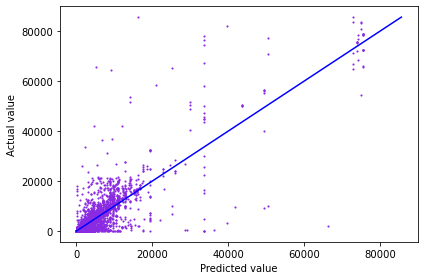

In [91]:
plot_performance('time', time_forest, scale='linear')